In [1]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [2]:
# Publication-ready plot configuration
import matplotlib.pyplot as plt
import matplotlib as mpl

# Font sizes
FONT_SIZE_LABEL = 18  # Axis labels and tick labels
FONT_SIZE_TITLE = 20  # Plot titles
FONT_SIZE_LEGEND = 18  # Legend text

# Configure matplotlib parameters globally
plt.rcParams.update({
    # Font sizes
    'font.size': FONT_SIZE_LABEL,          # Base font size
    'axes.labelsize': FONT_SIZE_LABEL,     # X and Y axis labels
    'axes.titlesize': FONT_SIZE_TITLE,     # Subplot titles
    'xtick.labelsize': FONT_SIZE_LABEL,    # X tick labels
    'ytick.labelsize': FONT_SIZE_LABEL,    # Y tick labels
    'legend.fontsize': FONT_SIZE_LEGEND,   # Legend
    
    # Font family
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    
    # Line widths
    'axes.linewidth': 1.5,                 # Axis border width
    'grid.linewidth': 1.0,                 # Grid line width
    'lines.linewidth': 2.0,                # Plot line width
    'lines.markersize': 8,                 # Default marker size
    
    # Tick parameters
    'xtick.major.width': 1.5,              # X tick width
    'ytick.major.width': 1.5,              # Y tick width
    'xtick.major.size': 6,                 # X tick length
    'ytick.major.size': 6,                 # Y tick length
    
    # Legend
    'legend.frameon': True,                # Legend frame
    'legend.framealpha': 0.8,              # Legend transparency
    'legend.edgecolor': 'black',           # Legend border color
    
    # Figure
    'figure.dpi': 100,                     # Display resolution
    'savefig.dpi': 300,                    # Save resolution for publication
    'savefig.bbox': 'tight',               # Tight bounding box
    'savefig.pad_inches': 0.1,             # Padding when saving
    
    # Grid
    'axes.grid': False,                    # No grid by default
    'grid.alpha': 0.3,                     # Grid transparency if enabled
})

print("✓ Publication-ready plot configuration loaded")
print(f"  - Axis labels/ticks: {FONT_SIZE_LABEL}pt")
print(f"  - Titles: {FONT_SIZE_TITLE}pt")
print(f"  - Save resolution: 300 DPI")

✓ Publication-ready plot configuration loaded
  - Axis labels/ticks: 18pt
  - Titles: 20pt
  - Save resolution: 300 DPI


In [3]:
import os
import json
import glob
import pandas as pd
from pathlib import Path

def load_all_model_results():
    """Load all model fit results from the model_fits directory"""
    results = []
    
    # Find all JSON files in model_fits directory
    json_files = glob.glob("model_fits/**/*.json", recursive=True)



    
    
    for file_path in json_files:
  
        try:
            with open(file_path, 'r') as f:
                result = json.load(f)
            
            # Extract participant ID and model type from filename if not in data
            filename = os.path.basename(file_path)
            parts = filename.replace('.json', '').split('_')
            #print(parts)
            if 'participantID' not in result:
                result['participantID'] = parts[0]

            
            result['modelType'] = parts[1]+"_"+parts[3]
            
            if parts[2]!="LapseFree":
                #print("Lapse fixed model, skipping")
                continue

            # Skip results with specific model types
            excluded_models = ["gaussian_sharedPrior", "fusionOnly_sharedPrior", "probabilityMatching_sharedPrior", "switching_sharedPrior"]
            if any(model in result['modelType'] for model in excluded_models):
                # Skip this result
                os.remove(file_path)
                continue
            

            results.append(result)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return results

# Load all results
all_results = load_all_model_results()
print(f"Loaded {len(all_results)} model fit results")

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(all_results)
print(f"Participants: {sorted(df_results['participantID'].unique())}")
print(f"Models: {sorted(df_results['modelType'].unique())}\n number of models in comparison is: {len(df_results['modelType'].unique())} ")


Loaded 78 model fit results
Participants: ['all', 'as', 'dt', 'hh', 'ip', 'ln1', 'ln2', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']
Models: ['fusionOnlyLogNorm_sharedPrior', 'logLinearMismatch_sharedPrior', 'lognorm_sharedPrior', 'probabilityMatchingLogNorm_sharedPrior', 'selection_sharedPrior', 'switchingFree_sharedPrior']
 number of models in comparison is: 6 


In [4]:
participantIds=sorted(df_results['participantID'].unique())
modelTypes=sorted(df_results['modelType'].unique())
nParticipants=len(participantIds)
nModels=len(modelTypes)

import fitSaver
import os

def loadSimulatedData(mc_fitter, dataName,participantID, modelType=None):
    participantID = dataName.split(".csv")[0]
    #modelType = mc_fitter.modelName

    if mc_fitter.sharedLambda:
        modelType += "_LapseFix"
    else:
        modelType += "_LapseFree"

    if mc_fitter.freeP_c:
        modelType += "_contextualPrior"
    else:
        modelType += "_sharedPrior"

    filename = f"{participantID.split('_')[0]}_{modelType}_simulated.csv"
    filename = os.path.join("simulated_data",participantID.split('_')[0], filename)
    try:
        
        simulatedData= pd.read_csv(filename)
        print(f"Loaded saved simulated data from {filename}")
        return simulatedData
    except:
        print(f"No saved simulated data found at {filename}")
        fitSaver.saveSimulatedData(mc_fitter, mc_fitter.dataName)
        mc_fitter.simulatedData= pd.read_csv(filename)
        print(f"Simulated data saved to {filename}")
        return mc_fitter.simulatedData
#proceed to simulate and save to {filename}
# eg., mc_fitter.simulatedData=loadSimulatedData(mc_fitter, mc_fitter.dataName, participantID=dataName.split(".csv")[0], modelType=mc_fitter.modelName)

# for each participant load simulated data and fit to psychometric functions and save the fitted params in psychometric_fits_simulated/participantID/participantID_modelType_psychometricFits.json
# no need to plot for now, just save the fitted params
import monteCarloClass

def fitPsychometricFunctions2SimulatedData(participantIDs, modelTypes):
    for participantID in participantIds:
        for modelType in ["lognorm"]:#modelTypes:
            row = df_results[(df_results['participantID'] == participantID) & (df_results['modelType'] == modelType)]
            sharedPrior = 'sharedPrior' in modelType
            modelType=modelType.split("_")[0]
            print(f"Processing participant {participantID}, model {modelType}, sharedPrior: {sharedPrior}")
            if row.empty:
                print(f"No results found for participant {participantID} and model {modelType}, skipping.")
                continue
            result = row.iloc[0].to_dict()
            
            data,dataName=loadData.loadData(participantID+"_all.csv")
            # Initialize monteCarloClass with the model parameters
            tmp_mc_fitter = monteCarloClass.OmerMonteCarlo(data)
            tmp_mc_fitter.modelName = result['modelType'].split("_")[0]
            tmp_mc_fitter.sharedLambda = 0
            tmp_mc_fitter.freeP_c = 0
            tmp_mc_fitter.dataName = dataName

            print(f"Simulating data for participant {participantID} using\n model {tmp_mc_fitter.modelName} with sharedLambda={tmp_mc_fitter.sharedLambda}, freeP_c={tmp_mc_fitter.freeP_c}")

            tmp_mc_fitter.modelFit= result['fittedParams']
            simulatedData = loadSimulatedData(mc_fitter=tmp_mc_fitter, dataName=tmp_mc_fitter.dataName,participantID=participantID, modelType=tmp_mc_fitter.modelName)
            simulatedData=  tmp_mc_fitter.simulateMonteCarloData(tmp_mc_fitter.modelFit, tmp_mc_fitter.data)

            tmp_mc_fitter.simulatedData = simulatedData
            tmp_mc_fitter.simDataFit=tmp_mc_fitter.fitMultipleStartingPoints(tmp_mc_fitter.simulatedData,1)
            # save to psychometric_fits_simulated/participantID/participantID_modelType_psychometricFits.json without fitSaver function
            save_dir = os.path.join("psychometric_fits_simulated", participantID.split('_')[0])
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f"{participantID}_{modelType}_psychometricFits.json")
            print(f"Saving psychometric fits for simulated data to {save_path}")
            fit_data = {
                'participantID': participantID,
                'modelType': modelType,
                'fitParams': tmp_mc_fitter.simDataFit.x.tolist(),  # Convert ndarray to list
            }
            # serialize to json
            with open(save_path, 'w') as f:
                json.dump(fit_data, f)
        
        
def fitPsychometric2RealData(participantIDs):
    for participantID in participantIds:
        row = df_results[(df_results['participantID'] == participantID)]
        print(f"Processing participant {participantID}")
        if row.empty:
            print(f"No results found for participant {participantID}, skipping.")
            continue
        result = row.iloc[0].to_dict()
        
        data,dataName=loadData.loadData(participantID+"_all.csv")
        # Initialize monteCarloClass with the model parameters
        tmp_mc_fitter = monteCarloClass.OmerMonteCarlo(data)

        tmp_mc_fitter.freeP_c = 1
        tmp_mc_fitter.dataName = dataName

        
        tmp_mc_fitter.realDataFit=tmp_mc_fitter.fitMultipleStartingPoints(tmp_mc_fitter.data,1)
        # save to psychometric_fits_real/participantID/participantID_modelType_psychometricFits.json without fitSaver function
        save_dir = os.path.join("psychometric_fits_real", participantID.split('_')[0])
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{participantID}_psychometricFits.json")
        print(f"Saving psychometric fits for real data to {save_path}")
        fit_data = {
            'participantID': participantID,
            'fitParams': tmp_mc_fitter.realDataFit.x.tolist(),  # Convert ndarray to list
        }
        # serialize to json
        with open(save_path, 'w') as f:
            json.dump(fit_data, f)

        
#fitPsychometricFunctions2SimulatedData(participantIds, modelTypes)

#fitPsychometric2RealData(participantIds)
   


In [33]:
modelTypes

['fusionOnlyLogNorm_sharedPrior',
 'logLinearMismatch_sharedPrior',
 'lognorm_sharedPrior',
 'probabilityMatchingLogNorm_sharedPrior',
 'selection_sharedPrior',
 'switchingFree_sharedPrior']

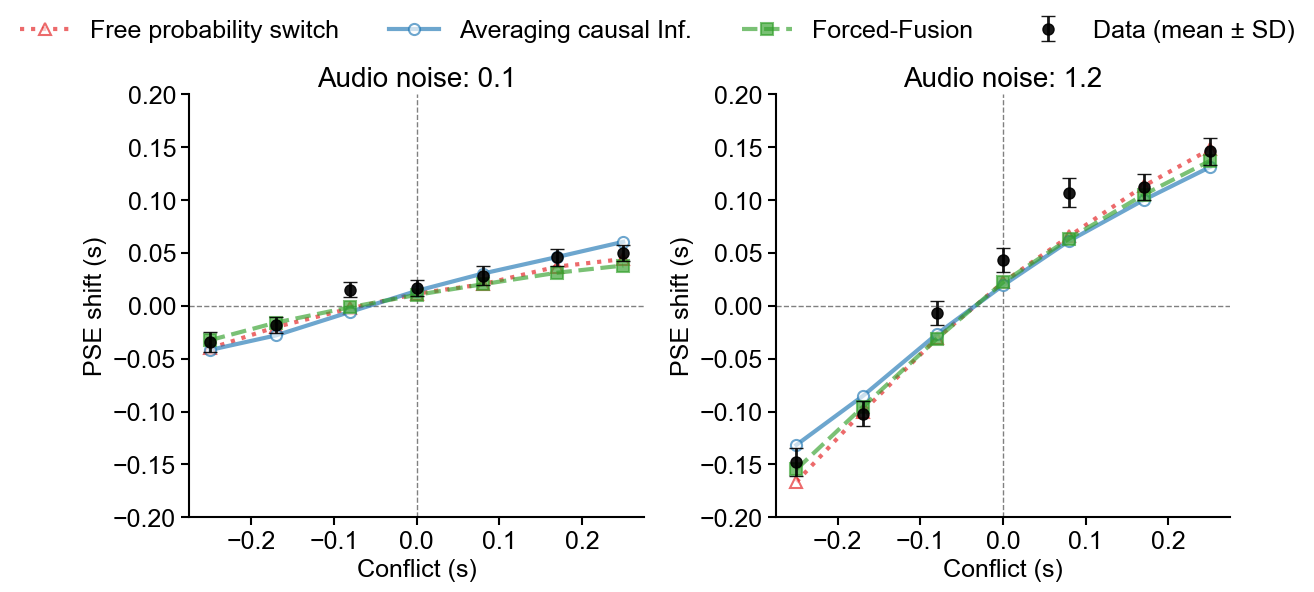

In [ ]:
# import bootstrapperSaveLoad functions
import matplotlib.pyplot as plt
from bootstrapperSaveLoad import saveBootstrappedParams, loadBootstrappedParams
import loadResults
import os
import json
import seaborn as sns


def plotAsFuncOfConflictAndSensoryNoise(participantIds, modelTypes, parameterToPLot="mu", show_grid=False):
    """
    Plot bootstrapped data (mean ± SD) vs. model predictions across conflict levels,
    for each audio noise level, per participant. Designed for journal-ready clarity.

    Parameters
    ----------
    participantIds : list[str]
        List of participant IDs (e.g., ['S01_all']).
    modelTypes : list[str]
        List of model type strings; base model is derived via split('_')[0].
    parameterToPLot : {'mu','sigma','lambda'}
        Which parameter to visualize:
        - 'mu'     : PSE shift (ms)
        - 'sigma'  : Psychometric σ
        - 'lambda' : Lapse rate
    show_grid : bool
        If True, show a light grid on subplots.
    """
    # Map selected parameter to index in `getParams` output
    param_index_map = {"lambda": 0, "mu": 1, "sigma": 2}
    param_label_map = {
        "mu": "PSE shift (s)",
        "sigma": "Psychometric σ",
        "lambda": "Lapse (λ)",
    }
    if parameterToPLot not in param_index_map:
        raise ValueError("parameterToPLot must be one of 'mu', 'sigma', 'lambda'")
    param_idx = param_index_map[parameterToPLot]
    y_label = param_label_map[parameterToPLot]

    # Colors and styles per base model to maximize identifiability
    base_model_types = sorted({mt.split("_")[0] for mt in modelTypes})
    palette_fallback = sns.color_palette("tab10", n_colors=max(3, len(base_model_types)))
    fallback_lookup = {m: palette_fallback[i] for i, m in enumerate(base_model_types)}
    model_display_name_map = {
        "lognorm": "Averaging causal Inf.",
        "fusionOnlyLognorm": "Forced-Fusion",
        "switchingFree": "Free probability switch",
    }
    model_style_map = {
        "lognorm": {"color": "#1f77b4", "linestyle": "-", "marker": "o", "markerfacecolor": "white"},
        "fusionOnlyLognorm": {"color": "#33a02c", "linestyle": "--", "marker": "s", "markerfacecolor": "#33a02c"},
        "switchingFree": {"color": "#e31a1c", "linestyle": ":", "marker": "^", "markerfacecolor": "white"},
    }

    lenSubjs = len(participantIds)
    fig = plt.figure(figsize=(12, 6 * lenSubjs))
    legend_handles, legend_labels = [], []
    seen_labels = set()

    for pNum, participantID in enumerate(participantIds):
        bootPath = participantID + "_dataFit_bootstrapped_params.json"
        dataBootsPath = os.path.join("bootstrapped_params", participantID.split('_')[0], bootPath)
        try:
            with open(dataBootsPath, 'r') as f:
                content = f.read().strip()
                dataBoots = json.loads(content) if content else []
            if not isinstance(dataBoots, list) or len(dataBoots) == 0:
                print(f"No bootstrapped params found or invalid format for {participantID} at {dataBootsPath}")
                continue
        except Exception as e:
            print(f"Error loading bootstrapped params for {participantID} from {dataBootsPath}: {e}")
            continue

        try:
            data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
        except Exception as e:
            print(f"Error loading data for {participantID}: {e}")
            continue
        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = False
        mc_fitter.dataName = dataName

        sensory_levels = sorted(mc_fitter.uniqueSensory)
        conflict_levels = sorted(mc_fitter.uniqueConflict)

        for j, audioNoiseLevel in enumerate(sensory_levels):
            ax = plt.subplot(lenSubjs, 2, (pNum * 2) + (j + 1))
            ax.set_title(f"Participant: {participantID} • Audio noise: {audioNoiseLevel}")
            ax.set_xlabel("Conflict (s)")
            ax.set_ylabel(y_label)
            ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
            ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
            if show_grid:
                ax.grid(True, alpha=0.3)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            data_means, data_stds = [], []
            for conflictLevel in conflict_levels:
                values = [mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)[param_idx] for boot in dataBoots]
                data_means.append(np.mean(values))
                data_stds.append(np.std(values))
            ax.errorbar(
                conflict_levels,
                data_means,
                yerr=data_stds,
                color="black",
                fmt='o',
                capsize=5,
                alpha=0.9,
                label="Data (mean ± SD)",
                zorder=5,
            )

            for modelType in modelTypes:
                base_model = modelType.split("_")[0]
                mc_fitter.modelName = base_model
                sim_fit_path = os.path.join(
                    "psychometric_fits_simulated",
                    participantID.split('_')[0],
                    f"{participantID}_{base_model}_psychometricFits.json"
                )
                try:
                    with open(sim_fit_path, 'r') as f:
                        sim_fit = json.load(f)
                except Exception as e:
                    print(f"Missing simulated fit for {participantID}, model {base_model}: {e}")
                    continue
                model_vals = [
                    mc_fitter.getParams(sim_fit['fitParams'], conflict, audioNoiseLevel)[param_idx]
                    for conflict in conflict_levels
                ]
                style = model_style_map.get(base_model, {})
                color_model = style.get('color', fallback_lookup.get(base_model, "#555555"))
                linestyle = style.get('linestyle', '-')
                marker = style.get('marker', 'o')
                markerface = style.get('markerfacecolor', color_model)
                display_label = model_display_name_map.get(base_model, base_model)
                ax.plot(
                    conflict_levels,
                    model_vals,
                    color=color_model,
                    alpha=0.65,
                    linestyle=linestyle,
                    linewidth=3,
                    marker=marker,
                    markerfacecolor=markerface,
                    markeredgecolor=color_model,
                    markeredgewidth=1.5,
                    markersize=8,
                    label=display_label,
                    zorder=4,
                )

            if parameterToPLot == "mu":
                ax.set_ylim(-0.2, 0.2)

            handles, labels = ax.get_legend_handles_labels()
            for handle, label in zip(handles, labels):
                if not label or label in seen_labels:
                    continue
                legend_handles.append(handle)
                legend_labels.append(label)
                seen_labels.add(label)

    if legend_handles:
        fig.legend(
            legend_handles,
            legend_labels,
            loc='upper center',
            ncol=max(1, min(4, len(legend_labels))),
            frameon=False,
            bbox_to_anchor=(0.5, 1.02),
        )
    plt.tight_layout(rect=(0, 0, 1, 0.95))
    #fig.savefig(f"aggregated_pse_vs_conflict_and_sensoryNoise.png", dpi=900)
    #return fig

# Example call (kept for reproducibility)
plotAsFuncOfConflictAndSensoryNoise(participantIds[:1], modelTypes=['switchingFree_sharedPrior', 'lognorm_sharedPrior','fusionOnlyLognorm_sharedPrior'], parameterToPLot="mu")

In [82]:
from collections import defaultdict

def aggregate_bootstrap_parameter(participantIds, parameterToPlot="mu"):
    """Aggregate bootstrapped parameter values across participants for grouped plotting."""
    param_index_map = {"lambda": 0, "mu": 1, "sigma": 2}
    if parameterToPlot not in param_index_map:
        raise ValueError("parameterToPlot must be one of 'mu', 'sigma', 'lambda'")
    param_idx = param_index_map[parameterToPlot]

    values_by_combo = defaultdict(list)
    contributors_by_combo = defaultdict(set)

    for participantID in participantIds:
        boot_filename = participantID + "_dataFit_bootstrapped_params.json"
        boot_path = os.path.join("bootstrapped_params", participantID.split('_')[0], boot_filename)
        if not os.path.exists(boot_path):
            print(f"Missing bootstrapped params for {participantID} at {boot_path}")
            continue
        try:
            with open(boot_path, 'r') as f:
                content = f.read().strip()
                dataBoots = json.loads(content) if content else []
        except Exception as e:
            print(f"Error reading {boot_path}: {e}")
            continue
        if not isinstance(dataBoots, list) or len(dataBoots) == 0:
            print(f"No bootstrapped samples for {participantID} in {boot_path}")
            continue

        try:
            data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
        except Exception as e:
            print(f"Error loading data for {participantID}: {e}")
            continue

        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = False
        mc_fitter.dataName = dataName

        sensory_levels = sorted(mc_fitter.uniqueSensory)
        conflict_levels = sorted(mc_fitter.uniqueConflict)

        for audioNoiseLevel in sensory_levels:
            for conflictLevel in conflict_levels:
                try:
                    values = [mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)[param_idx] for boot in dataBoots]
                except Exception as e:
                    print(f"Skipping {participantID} ({conflictLevel}, {audioNoiseLevel}): {e}")
                    continue
                if not values:
                    continue
                key = (audioNoiseLevel, conflictLevel)
                values_by_combo[key].extend(values)
                contributors_by_combo[key].add(participantID)

    rows = []
    for (audioNoiseLevel, conflictLevel), values in sorted(values_by_combo.items()):
        rows.append({
            "audioNoise": audioNoiseLevel,
            "conflict": conflictLevel,
            "mean": float(np.mean(values)),
            "std": float(np.std(values)),
            "n_bootstrap_samples": len(values),
            "n_participants": len(contributors_by_combo[(audioNoiseLevel, conflictLevel)])
        })

    return pd.DataFrame(rows)


def aggregate_model_predictions(participantIds, modelTypes, parameterToPlot="mu"):
    """Aggregate model predictions across participants for grouped plotting."""
    if len(modelTypes) == 0:
        return pd.DataFrame()
    param_index_map = {"lambda": 0, "mu": 1, "sigma": 2}
    if parameterToPlot not in param_index_map:
        raise ValueError("parameterToPlot must be one of 'mu', 'sigma', 'lambda'")
    param_idx = param_index_map[parameterToPlot]

    values_by_combo = defaultdict(list)
    contributors_by_combo = defaultdict(set)

    for participantID in participantIds:
        try:
            data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
        except Exception as e:
            print(f"Error loading data for {participantID}: {e}")
            continue

        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = False
        mc_fitter.dataName = dataName

        sensory_levels = sorted(mc_fitter.uniqueSensory)
        conflict_levels = sorted(mc_fitter.uniqueConflict)

        for modelType in modelTypes:
            base_model = modelType.split("_")[0]
            sim_fit_path = os.path.join(
            "psychometric_fits_simulated",
            participantID.split('_')[0],
            f"{participantID}_{base_model}_psychometricFits.json")
            if not os.path.exists(sim_fit_path):
                print(f"Missing simulated fit for {participantID}, model {base_model}: {sim_fit_path}")
                continue
            try:
                with open(sim_fit_path, 'r') as f:
                    sim_fit = json.load(f)
            except Exception as e:
                print(f"Error reading {sim_fit_path}: {e}")
                continue

            for audioNoiseLevel in sensory_levels:
                for conflictLevel in conflict_levels:
                    try:
                        value = mc_fitter.getParams(sim_fit['fitParams'], conflictLevel, audioNoiseLevel)[param_idx]
                    except Exception as e:
                        print(f"Skipping model {base_model} for {participantID} ({conflictLevel}, {audioNoiseLevel}): {e}")
                        continue
                    key = (base_model, audioNoiseLevel, conflictLevel)
                    values_by_combo[key].append(value)
                    contributors_by_combo[key].add(participantID)

    rows = []
    for (base_model, audioNoiseLevel, conflictLevel), values in sorted(values_by_combo.items(), key=lambda item: (item[0][1], item[0][2], item[0][0])):
        rows.append({
            "model": base_model,
            "audioNoise": audioNoiseLevel,
            "conflict": conflictLevel,
            "mean": float(np.mean(values)),
            "std": float(np.std(values)),
            "n_participants": len(contributors_by_combo[(base_model, audioNoiseLevel, conflictLevel)])
        })

    return pd.DataFrame(rows)


parameter_to_plot = "mu"
models_to_plot = ['switchingFree_sharedPrior', 'lognorm_sharedPrior', 'fusionOnlyLognorm_sharedPrior']

grouped_data_stats = aggregate_bootstrap_parameter(participantIds[1:], parameter_to_plot)
grouped_model_stats = aggregate_model_predictions(participantIds[1:], models_to_plot, parameter_to_plot)

print(f"Aggregated data rows: {len(grouped_data_stats)}")
print(f"Aggregated model rows: {len(grouped_model_stats)}")

Aggregated data rows: 14
Aggregated model rows: 42


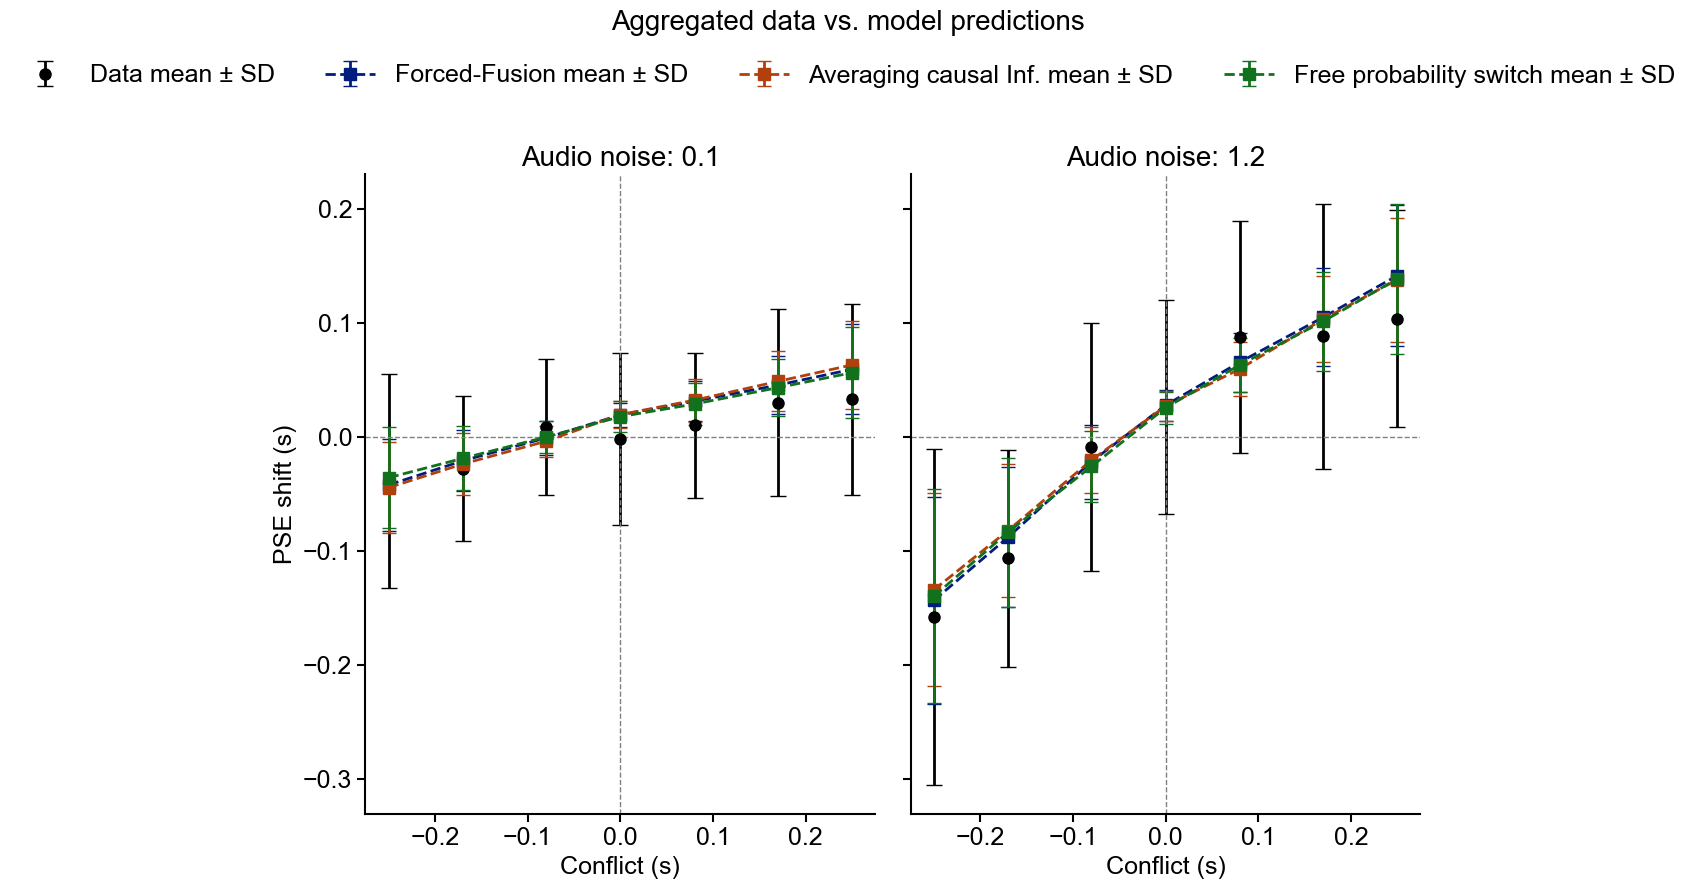

In [ ]:
def plot_grouped_data_vs_models(grouped_data_stats, grouped_model_stats, parameterToPlot="mu", show_grid=False):
    """Plot aggregated data and model predictions with mean ± SD error bars."""
    if grouped_data_stats is None or grouped_data_stats.empty:
        print("No aggregated data available to plot.")
        return None
    param_label_map = {
        "mu": "PSE shift (s)",
        "sigma": "Psychometric σ",
        "lambda": "Lapse (λ)",
    }
    if parameterToPlot not in param_label_map:
        raise ValueError("parameterToPlot must be one of 'mu', 'sigma', 'lambda'")
    audio_levels = sorted(grouped_data_stats['audioNoise'].unique().tolist())
    if grouped_model_stats is not None and not grouped_model_stats.empty:
        audio_levels = sorted(set(audio_levels).union(set(grouped_model_stats['audioNoise'].unique())))
    n_cols = len(audio_levels)
    fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 8), sharey=True)
    if n_cols == 1:
        axes = [axes]
    model_names = []
    model_color_lookup = {}
    model_offsets = {}
    if grouped_model_stats is not None and not grouped_model_stats.empty:
        model_names = sorted(grouped_model_stats['model'].unique())
        palette = sns.color_palette("dark", n_colors=max(3, len(model_names)))
        model_color_lookup = {model_names[i]: palette[i] for i in range(len(model_names))}
        # horizontal offsets prevent overlap when means coincide
        offset_span = 0.004
        mid = (len(model_names) - 1) / 2
        model_offsets = {model_names[i]: (i - mid) * offset_span for i in range(len(model_names))}
    model_display_name_map = {
        "lognorm": "Averaging causal Inf.",
        "fusionOnlyLognorm": "Forced-Fusion",
        "switchingFree": "Free probability switch",
    }
    model_style_map = {
        "lognorm": {"linestyle": "-", "marker": "o"},
        "fusionOnlyLognorm": {"linestyle": "--", "marker": "s"},
        "switchingFree": {"linestyle": ":", "marker": "^"},
    }

    for ax, audio_noise in zip(axes, audio_levels):
        subset_data = grouped_data_stats[grouped_data_stats['audioNoise'] == audio_noise].sort_values('conflict')
        if not subset_data.empty:
            ax.errorbar(
                subset_data['conflict'],
                subset_data['mean'],
                yerr=subset_data['std'],
                color='black',
                fmt='o',
                capsize=6,
                alpha=0.9,
                label='Data mean ± SD',
                zorder=6,
            )
        if model_names:
            for model_name in model_names:
                subset_model = grouped_model_stats[
                    (grouped_model_stats['audioNoise'] == audio_noise)
                    & (grouped_model_stats['model'] == model_name)
                ].sort_values('conflict')
                if subset_model.empty:
                    continue
                display_model_name = model_display_name_map.get(model_name, model_name)
                color = model_color_lookup[model_name]
                linestyle = model_style_map.get(model_name, {}).get('linestyle', '-')
                marker = model_style_map.get(model_name, {}).get('marker', 'o')
                x_vals = subset_model['conflict'].to_numpy(dtype=float)
                offset = model_offsets.get(model_name, 0.0)
                x_shifted = x_vals + offset
                means = subset_model['mean'].to_numpy(dtype=float)
                stds = subset_model['std'].to_numpy(dtype=float)
                ax.fill_between(
                    x_shifted,
                    means - stds,
                    means + stds,
                    color=color,
                    alpha=0.12,
                    linewidth=0,
                    zorder=3,
                )
                ax.errorbar(
                    x_shifted,
                    means,
                    yerr=stds,
                    color=color,
                    linestyle=linestyle,
                    marker=marker,
                    markerfacecolor='white',
                    markeredgewidth=1.3,
                    capsize=5,
                    linewidth=2.5,
                    label=f"{display_model_name} mean ± SD",
                    zorder=4,
                )
        ax.axhline(0, color='gray', linestyle='--', linewidth=1)
        ax.axvline(0, color='gray', linestyle='--', linewidth=1)
        ax.set_xlabel("Conflict (s)")
        ax.set_title(f"Audio noise: {audio_noise}")
        if show_grid:
            ax.grid(True, alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    axes[0].set_ylabel(param_label_map[parameterToPlot])
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper center', ncol=max(1, len(labels)), frameon=False, bbox_to_anchor=(0.5, 1.08))
    fig.suptitle("Aggregated data vs. model predictions", y=1.12, fontsize=FONT_SIZE_TITLE)
    plt.tight_layout(rect=(0, 0, 1, 1.05))
    #return fig


plot_grouped_data_vs_models(grouped_data_stats, grouped_model_stats, parameter_to_plot)

In [ ]:
modelTypes
['switchingFree_sharedPrior', 'lognorm_sharedPrior']

['fusionOnlyLogNorm_sharedPrior',
 'logLinearMismatch_sharedPrior',
 'lognorm_sharedPrior',
 'probabilityMatchingLogNorm_sharedPrior',
 'selection_sharedPrior',
 'switchingFree_sharedPrior']